# Enrichment analysis of gene regulatory networks inferred from COVID-9 patients

This notebook contains the enrichment analysis of gene regulatory networks (GRNs) computed on scRNA-seq data of COVID-19 patients ([Liao *et al.*, 2020](https://www.nature.com/articles/s41591-020-0901-9)). The enrichment analysis focuses on identifying the functional terms that are ***enriched*** for the queried set of genes. For an overview of different methods used for enrichment analysis the reader can look [here](https://yulab-smu.top/biomedical-knowledge-mining-book/enrichment-overview.html).

This notebook integrates the results of [`EnrichR`](https://maayanlab.cloud/Enrichr/) enrichment web tool and visualize them using [`enrichplot`](https://yulab-smu.top/biomedical-knowledge-mining-book/enrichplot.html) (i.e. [`clusterProfiler`](https://yulab-smu.top/biomedical-knowledge-mining-book/index.html)). The following questions could be answered:

- What biological processes and functions could be attributed to activated genes in GRNs?
- What is the functional phenotype of different patient groups (i.e. "C", "M" and "S")?
- What is the functional characterization of obtained graph communities in GRNs?

# Setting up the environment..

In [3]:
# Generic
import sys  # managing environmental variables
import os  # file system
import warnings  # managing warnings
from glob import glob  # globbing
import multiprocessing  # parallel execution

# Data managing
import ndex2  # database of biological network
import numpy as np  # scientific programming
import pandas as pd  # working with tabular data

# Graphs
import networkx as nx  # working with network data
import igraph as ig  # working with network data
import leidenalg as la  # community detection
from community import community_louvain  # community detection
from venn import venn, pseudovenn, generate_petal_labels, draw_venn, draw_pseudovenn6  # venn diagram visualization

# Visualization
import matplotlib as mpl  # general visualization
import matplotlib.pyplot as plt  # general visualization
import seaborn as sns  # fancy visualizations
import colorcet as cc  # colormaps
from matplotlib.colors import ListedColormap  # colormaps
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches  # color patches
from wordcloud import WordCloud  # wordcloud visualization
import matplotlib_venn_wordcloud  # workcloud visualization

# Tools/utils
from sklearn.preprocessing import MinMaxScaler  # scaling data
from collections import Counter  # item counter
from functools import reduce  # for aggregate functions
from termcolor import colored  # colored text output
from tqdm.notebook import tqdm  # progress bar logging
import itertools  # tools for iterative objects
from itertools import chain, zip_longest
import textwrap
import re

# Setting working directory as home
home_dir = os.path.expanduser('~')
os.chdir(os.path.expanduser('~/scGRN_analysis'))
multiprocessing.process.ORIGINAL_DIR = os.path.abspath(os.getcwd())

# Getting the tools for GRN analysis
import scGRN

# Jupyter utils
from IPython.display import display  # displaying results in jupyter
from ipywidgets import *  # interactive widgets

# Bridge to R
import rpy2.rinterface
%load_ext rpy2.ipython

# To reload packages - # %autoreload 2
%load_ext autoreload
# To obtain line-by-line profile of execution time
%load_ext line_profiler

# Other parameters
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
_N_JOBS = max(1, multiprocessing.cpu_count() - 2)
_SEED = 42
np.random.seed(_SEED)
_NODE_SIZE = 1200
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.dpi'] = 200
sns.set_style("whitegrid")
blue = (221 / 256, 232 / 256, 250 / 256)
dark_blue = (115 / 256, 141 / 256, 187 / 256)
yellow = (253 / 256, 242 / 256, 208 / 256)
dark_yellow = (209 / 256, 183 / 256, 101 / 256)

# Loading ggplot2 default colors
colors = scGRN.ggcolors

### Setting up R

In [26]:
%%R
suppressPackageStartupMessages({
  #if (!require("pacman")) install.packages("pacman")
  #list.of.packages <- c("BiocManager","dplyr","SingleR","Matrix","Seurat","future","pheatmap","ggplot2","optparse","hdf5r")
  #BiocManager::install("SingleR")
  #BiocManager::install('limma')
  #BiocManager::install('SingleCellExperiment')
  #pacman::p_load(list.of.packages, character.only = TRUE)
  library(SingleR)
  library(Matrix)
  library(Seurat)
  library(dplyr)
  library(future)
  library(pheatmap)
  library(ggplot2)
  library(optparse)
  library(clusterProfiler)
  library(org.Hs.eg.db)
  library(multienrichjam)
  library(plyr)
  library(stringr)
})

# Define colors
colors <- list(green='#39B600', yellow='#D89000', red='#F8766D', blue='#00B0F6', 
               purple='#9590FF', cyan='#00BFC4', pink='E76BF3', light_pink='#FF62BC',
               saturated_green='#00BF7D')

remove_legend_title <- function(ggplot2_object) {
  # Delete the unwanted layers.
  layers <- ggplot2_object$layers[-7]
  ggplot2_object$layers <- layers
  ggplot2_object
}

# Setting up data
## Getting metadata

In [49]:
# Setting pathways to data files
_PROJ_HOME = '/gpfs/projects/bsc08/shared_projects/scGRN_analysis'  # also scGRN._PROJ_HOME
_FMETA = f'{_PROJ_HOME}/Data_home/data/GSE145926_RAW/metadata.tsv'  # also scGRN._META_FILE
_DATA_HOME = f'{_PROJ_HOME}/Data_home/res/covid_19'  # also scGRN._DATA_HOME
_FIG_HOME = f'{_PROJ_HOME}/Data_home/notebook_figs'
fig_home = _FIG_HOME

# Loading patient metadata
full_meta = scGRN.ana.get_meta(_DATA_HOME, _FMETA)

# Displaying full metadata
print('Full metadata:')
full_meta

Full metadata:


,group,file,num_cells,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,...,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
id,,,,,,,,,,,,,,,,,,,,,
C51,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,9431.0,8348.0,608.0,215.0,98.0,70.0,68.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C52,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,8696.0,8611.0,13.0,23.0,3.0,14.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,907.0,338.0,411.0,45.0,5.0,51.0,20.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C141,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,1449.0,197.0,932.0,48.0,5.0,86.0,96.0,33.0,...,11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C142,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,1790.0,482.0,996.0,39.0,13.0,67.0,113.0,20.0,...,14.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C144,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,452.0,37.0,181.0,41.0,8.0,73.0,34.0,14.0,...,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C143,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,14933.0,2048.0,1394.0,154.0,33.0,7489.0,562.0,72.0,...,3005.0,2.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN
C145,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,15550.0,6960.0,719.0,859.0,46.0,5616.0,421.0,58.0,...,635.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C146,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,2545.0,247.0,61.0,36.0,NaN,127.0,14.0,3.0,...,1632.0,NaN,NaN,1.0,NaN,2.0,1.0,1.0,1.0,NaN


# Enrichment analysis of TFs based on `VIPER` scores

We will start by investigating the functional terms obtained from `EnrichR` on TF markers calculated with `VIPER` activity score. 

## T cells

The `EnrichR` results were produced with the following command:

```python
python run_enrichr.py -i /gpfs/projects/bsc08/shared_projects/scGRN_analysis/Data_home/res/covid_19/cell_types/T_cells/data/Seurat/regulon/tf_markers_df_T_cells.tsv -g gene -c cluster -q ''p_val_adj' < 0.05 & 'avg_log2FC' > 1'
```

### Loading the data

In [50]:
cell_type = 'T_cells'
types = ['C', 'M', 'S']
db = 'Reactome_2016'
is_positive_markers = True  # True if extract only positive markers

tf_markers_df = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'Seurat', 
    'regulon', f'tf_markers_df_{cell_type}.tsv'
), sep='\t')

if is_positive_markers:
    tf_markers_df = tf_markers_df[
        (tf_markers_df['p_val_adj'] < 0.05) & (tf_markers_df['avg_log2FC'] > 1)
    ]
else:
    tf_markers_df = tf_markers_df[
        (tf_markers_df['p_val_adj'] < 0.05) & (tf_markers_df['avg_log2FC'] < -1)
    ]
genes = tf_markers_df[['cluster', 'gene']].groupby('cluster').agg(lambda x: list(x)).to_dict()['gene']

enrichr_res = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'Seurat', 
    'regulon', f'enrichr_{db}_tf_markers_df_{cell_type}.tsv'
), sep='\t')

print('The TF markers based on differential analysis of VIPER scores:')
display(tf_markers_df)
print()
print('Corresponding enriched functional terms using EnrichR:')
display(enrichr_res)

The TF markers based on differential analysis of VIPER scores:


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
IRF2,0.000000e+00,8.346623,0.050,0.005,0.000000e+00,M,IRF2
STAT1,0.000000e+00,5.006633,0.002,0.000,0.000000e+00,M,STAT1
NR3C1,0.000000e+00,4.831237,0.092,0.002,0.000000e+00,M,NR3C1
IRF1,0.000000e+00,4.676670,0.002,0.000,0.000000e+00,M,IRF1
REST,0.000000e+00,4.024687,0.215,0.016,0.000000e+00,M,REST
...,...,...,...,...,...,...,...
ETS1.1,6.443768e-06,2.823151,0.024,0.005,9.794528e-04,S,ETS1
SPIB.1,8.960491e-05,1.980578,0.737,0.653,1.361995e-02,S,SPIB
BCL11A.2,4.266713e-268,3.920791,1.000,1.000,6.485404e-266,C,BCL11A
JUND.2,2.616454e-237,2.604915,0.273,0.040,3.977010e-235,C,JUND



Corresponding enriched functional terms using EnrichR:


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,cluster
0,Interferon alpha/beta signaling Homo sapiens R...,8/68,5.593075e-12,1.359117e-09,0,0,63.142857,1635.999345,IRF3;IRF4;STAT1;IRF1;STAT2;IRF2;IRF7;IRF9,M
1,Interferon gamma signaling Homo sapiens R-HSA-...,7/93,3.171126e-09,3.852918e-07,0,0,37.600865,735.818071,IRF3;IRF4;STAT1;IRF1;IRF2;IRF7;IRF9,M
2,Interferon Signaling Homo sapiens R-HSA-913531,8/196,2.782704e-08,2.253990e-06,0,0,20.022290,348.332936,IRF3;IRF4;STAT1;IRF1;STAT2;IRF2;IRF7;IRF9,M
3,Circadian Clock Homo sapiens R-HSA-400253,5/63,5.010714e-07,3.044009e-05,0,0,38.107280,552.803907,CREB1;RORA;NR3C1;MEF2D;ARNTL,M
4,TRAF6 mediated IRF7 activation Homo sapiens R-...,4/32,1.180068e-06,5.735129e-05,0,0,61.869565,844.515771,IRF3;IRF1;IRF2;IRF7,M
...,...,...,...,...,...,...,...,...,...,...
376,Disease Homo sapiens R-HSA-1643685,2/725,4.407329e-01,4.538891e-01,0,0,1.364400,1.117875,MYC;NFKB2,S
377,Diseases of signal transduction Homo sapiens R...,1/288,4.485978e-01,4.585667e-01,0,0,1.713589,1.373662,MYC,S
378,Signaling by Rho GTPases Homo sapiens R-HSA-19...,1/367,5.323824e-01,5.402115e-01,0,0,1.338320,0.843668,SRF,S
379,Signaling by Interleukins Homo sapiens R-HSA-4...,1/392,5.562078e-01,5.602677e-01,0,0,1.251151,0.733942,NFKB2,S


### Processing the data

We need to process the `EnrichR` output to use `clusterProfiler` for visualization.

In [51]:
processed_types = enrichr_res['cluster'].unique()
enrichr_res_processed = (
    enrichr_res.rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score', 'cluster': 'type'})
        .assign(
            Genes=enrichr_res['Genes'].map(lambda x: x.replace(';', '/')),
            Ratio=enrichr_res.apply(
                lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[x['cluster']])}", 
                axis=1
            )
        )        
)
if db == 'Reactome_2016':
    enrichr_res_processed['Term'] = enrichr_res_processed['Term'].map(lambda x: x[:x.find('Homo')-1])
final_df = enrichr_res_processed.assign(ID=[f'ID_{el}' for el in pd.factorize(enrichr_res_processed['Term'])[0] + 1])

print('Processed dataframe:')
final_df

Processed


,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Interferon alpha/beta signaling,8/68,5.593075e-12,1.359117e-09,0,0,63.142857,1635.999345,IRF3/IRF4/STAT1/IRF1/STAT2/IRF2/IRF7/IRF9,M,8/50,ID_1
1,Interferon gamma signaling,7/93,3.171126e-09,3.852918e-07,0,0,37.600865,735.818071,IRF3/IRF4/STAT1/IRF1/IRF2/IRF7/IRF9,M,7/50,ID_2
2,Interferon Signaling,8/196,2.782704e-08,2.253990e-06,0,0,20.022290,348.332936,IRF3/IRF4/STAT1/IRF1/STAT2/IRF2/IRF7/IRF9,M,8/50,ID_3
3,Circadian Clock,5/63,5.010714e-07,3.044009e-05,0,0,38.107280,552.803907,CREB1/RORA/NR3C1/MEF2D/ARNTL,M,5/50,ID_4
4,TRAF6 mediated IRF7 activation,4/32,1.180068e-06,5.735129e-05,0,0,61.869565,844.515771,IRF3/IRF1/IRF2/IRF7,M,4/50,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
376,Disease,2/725,4.407329e-01,4.538891e-01,0,0,1.364400,1.117875,MYC/NFKB2,S,2/41,ID_90
377,Diseases of signal transduction,1/288,4.485978e-01,4.585667e-01,0,0,1.713589,1.373662,MYC,S,1/41,ID_92
378,Signaling by Rho GTPases,1/367,5.323824e-01,5.402115e-01,0,0,1.338320,0.843668,SRF,S,1/41,ID_302
379,Signaling by Interleukins,1/392,5.562078e-01,5.602677e-01,0,0,1.251151,0.733942,NFKB2,S,1/41,ID_128


### Moving to `R` using `rpy2`

In [33]:
%%R -i final_df,processed_types,fig_home,cell_type

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

merge_cmd = ""
for (t in processed_types){
    merge_cmd = paste0(merge_cmd, sprintf("%s=egos[['%s']], ", t, t))
}

merge_cmd = sprintf("merge_result(list(%s))", substr(merge_cmd, 1, nchar(merge_cmd) - 2))

ck <- eval(parse(text=merge_cmd))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



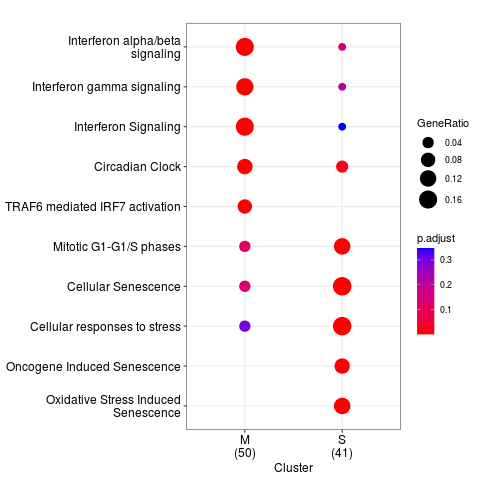

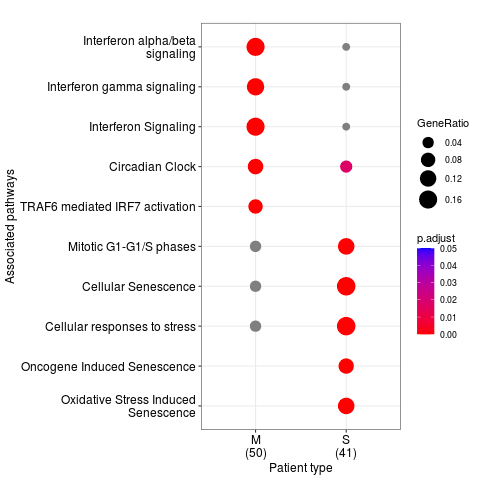

In [34]:
%%R
p <- dotplot(ck, showCategory=5) + 
    labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
# ggsave(p, filename=sprintf('%s/dotplot_enrichr_tf_markers_%s.pdf', fig_home, cell_type), width=7, height=8)
p

### Cnetplot

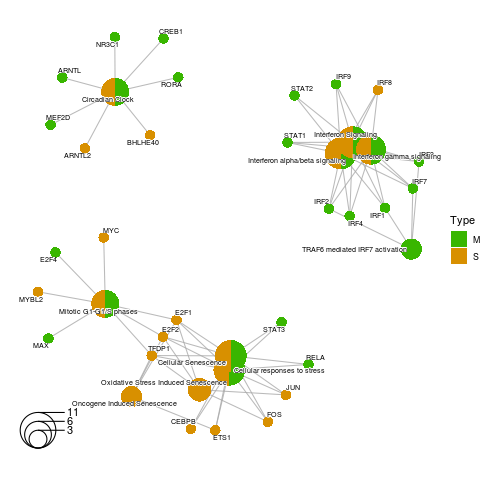

In [28]:
%%R
p <- cnetplot(ck, cex_category=1) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
# ggsave(p, filename=sprintf('%s/cnetplot_enrichr_tf_markers_%s.pdf', fig_home, cell_type))
p

## Macrophages

The `EnrichR` results were produced with the following command:

```python
python run_enrichr.py -i /gpfs/projects/bsc08/shared_projects/scGRN_analysis/Data_home/res/covid_19/cell_types/Macrophage/data/Seurat/regulon/tf_markers_df_Macrophage.tsv -g gene -c cluster -q ''p_val_adj' < 0.05 & 'avg_log2FC' > 1'
```

### Loading the data

In [52]:
cell_type = 'Macrophage'
types = ['C', 'M', 'S']
db = 'Reactome_2016'
is_positive_markers = True  # True if extract only positive markers

tf_markers_df = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'Seurat', 
    'regulon', f'tf_markers_df_{cell_type}.tsv'
), sep='\t')

if is_positive_markers:
    tf_markers_df = tf_markers_df[
        (tf_markers_df['p_val_adj'] < 0.05) & (tf_markers_df['avg_log2FC'] > 1)
    ]
else:
    tf_markers_df = tf_markers_df[
        (tf_markers_df['p_val_adj'] < 0.05) & (tf_markers_df['avg_log2FC'] < -1)
    ]
genes = tf_markers_df[['cluster', 'gene']].groupby('cluster').agg(lambda x: list(x)).to_dict()['gene']

enrichr_res = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'Seurat', 
    'regulon', f'enrichr_{db}_tf_markers_df_{cell_type}.tsv'
), sep='\t')

print('The TF markers based on differential analysis of VIPER scores:')
display(tf_markers_df)
print()
print('Corresponding enriched functional terms using EnrichR:')
display(enrichr_res)

The TF markers based on differential analysis of VIPER scores:


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
IRF4,8.750582e-70,1.288576,0.736,0.381,1.102573e-67,M,IRF4
NR1H2,2.275548e-04,1.040075,0.560,0.547,2.867190e-02,M,NR1H2
NFKB2.1,0.000000e+00,17.302542,0.135,0.001,0.000000e+00,S,NFKB2
NFKB1.1,0.000000e+00,14.800592,0.125,0.001,0.000000e+00,S,NFKB1
RELA.1,0.000000e+00,14.232002,0.199,0.002,0.000000e+00,S,RELA
...,...,...,...,...,...,...,...
RXRA.2,0.000000e+00,3.320984,0.596,0.234,0.000000e+00,C,RXRA
E2F1.2,0.000000e+00,2.897388,0.854,0.614,0.000000e+00,C,E2F1
REST.2,0.000000e+00,2.300194,0.719,0.228,0.000000e+00,C,REST
USF2.2,7.315586e-149,1.760253,0.094,0.090,9.217638e-147,C,USF2



Corresponding enriched functional terms using EnrichR:


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,cluster
0,Nuclear Receptor transcription pathway Homo sa...,3/51,0.000007,0.000744,0,0,103.838542,1233.189351,ESRRA;RXRA;RARA,C
1,Activation of anterior HOX genes in hindbrain ...,3/89,0.000037,0.001330,0,0,57.845930,589.850033,YY1;RXRA;RARA,C
2,Activation of HOX genes during differentiation...,3/89,0.000037,0.001330,0,0,57.845930,589.850033,YY1;RXRA;RARA,C
3,Transcriptional activation of mitochondrial bi...,2/40,0.000403,0.009507,0,0,80.757085,631.279748,ESRRA;RXRA,C
4,Signaling by Retinoic Acid Homo sapiens R-HSA-...,2/42,0.000444,0.009507,0,0,76.711538,592.142891,RXRA;RARA,C
...,...,...,...,...,...,...,...,...,...,...
342,Axon guidance Homo sapiens R-HSA-422475,1/515,0.882762,0.897295,0,0,0.466061,0.058118,CREB1,S
343,Post-translational protein modification Homo s...,1/521,0.885692,0.897295,0,0,0.460541,0.055903,MITF,S
344,Metabolism of lipids and lipoproteins Homo sap...,1/659,0.936268,0.944409,0,0,0.361364,0.023797,SREBF1,S
345,Signaling by GPCR Homo sapiens R-HSA-372790,1/1293,0.995878,0.997439,0,0,0.177980,0.000735,CREB1,S


### Processing the data

We need to process the `EnrichR` output to use `clusterProfiler` for visualization.

In [53]:
processed_types = enrichr_res['cluster'].unique()
enrichr_res_processed = (
    enrichr_res.rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score', 'cluster': 'type'})
        .assign(
            Genes=enrichr_res['Genes'].map(lambda x: x.replace(';', '/')),
            Ratio=enrichr_res.apply(
                lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[x['cluster']])}", 
                axis=1
            )
        )        
)
if db == 'Reactome_2016':
    enrichr_res_processed['Term'] = enrichr_res_processed['Term'].map(lambda x: x[:x.find('Homo')-1])
final_df = enrichr_res_processed.assign(ID=[f'ID_{el}' for el in pd.factorize(enrichr_res_processed['Term'])[0] + 1])

print('Processed dataframe:')
final_df

Processed


,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Nuclear Receptor transcription pathway,3/51,0.000007,0.000744,0,0,103.838542,1233.189351,ESRRA/RXRA/RARA,C,3/15,ID_1
1,Activation of anterior HOX genes in hindbrain ...,3/89,0.000037,0.001330,0,0,57.845930,589.850033,YY1/RXRA/RARA,C,3/15,ID_2
2,Activation of HOX genes during differentiation,3/89,0.000037,0.001330,0,0,57.845930,589.850033,YY1/RXRA/RARA,C,3/15,ID_3
3,Transcriptional activation of mitochondrial bi...,2/40,0.000403,0.009507,0,0,80.757085,631.279748,ESRRA/RXRA,C,2/15,ID_4
4,Signaling by Retinoic Acid,2/42,0.000444,0.009507,0,0,76.711538,592.142891,RXRA/RARA,C,2/15,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
342,Axon guidance,1/515,0.882762,0.897295,0,0,0.466061,0.058118,CREB1,S,1/82,ID_281
343,Post-translational protein modification,1/521,0.885692,0.897295,0,0,0.460541,0.055903,MITF,S,1/82,ID_282
344,Metabolism of lipids and lipoproteins,1/659,0.936268,0.944409,0,0,0.361364,0.023797,SREBF1,S,1/82,ID_84
345,Signaling by GPCR,1/1293,0.995878,0.997439,0,0,0.177980,0.000735,CREB1,S,1/82,ID_283


### Moving to `R` using `rpy2`

In [37]:
%%R -i final_df,processed_types,fig_home,cell_type

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

merge_cmd = ""
for (t in processed_types){
    merge_cmd = paste0(merge_cmd, sprintf("%s=egos[['%s']], ", t, t))
}

merge_cmd = sprintf("merge_result(list(%s))", substr(merge_cmd, 1, nchar(merge_cmd) - 2))

ck <- eval(parse(text=merge_cmd))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



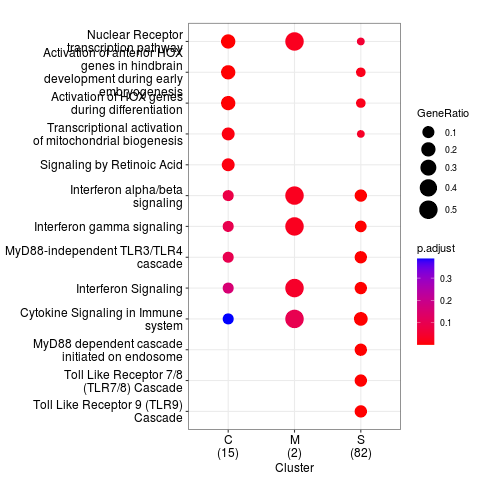

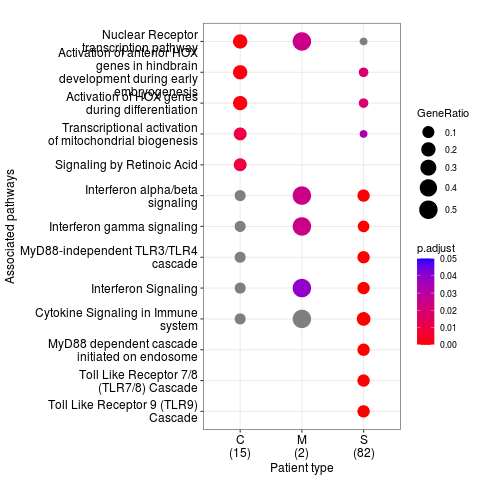

In [38]:
%%R
p <- dotplot(ck, showCategory=5) + 
    labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
# ggsave(p, filename=sprintf('%s/dotplot_enrichr_tf_markers_%s.pdf', fig_home, cell_type), width=7, height=8)
p

### Cnetplot

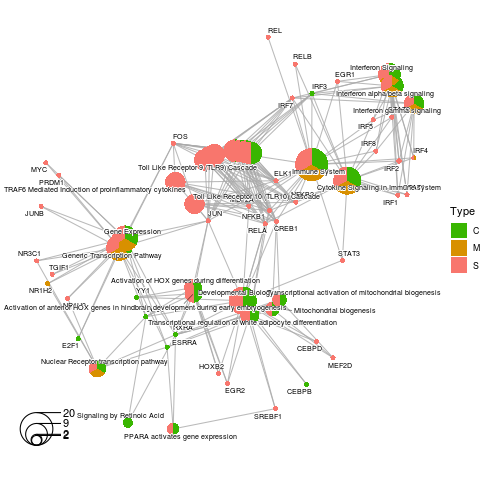

In [40]:
%%R
p <- cnetplot(ck, cex_category=1, 10) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
# ggsave(p, filename=sprintf('%s/cnetplot_enrichr_tf_markers_%s.pdf', fig_home, cell_type))
p

## NK cells

The `EnrichR` results were produced with the following command:

```python
python run_enrichr.py -i /gpfs/projects/bsc08/shared_projects/scGRN_analysis/Data_home/res/covid_19/cell_types/NK_cell/data/Seurat/regulon/tf_markers_df_NK_cell.tsv -g gene -c cluster -q ''p_val_adj' < 0.05 & 'avg_log2FC' > 1'
```

### Loading the data

In [54]:
cell_type = 'NK_cell'
types = ['C', 'M', 'S']
db = 'Reactome_2016'
is_positive_markers = True  # True if extract only positive markers

tf_markers_df = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'Seurat', 
    'regulon', f'tf_markers_df_{cell_type}.tsv'
), sep='\t')

if is_positive_markers:
    tf_markers_df = tf_markers_df[
        (tf_markers_df['p_val_adj'] < 0.05) & (tf_markers_df['avg_log2FC'] > 1)
    ]
else:
    tf_markers_df = tf_markers_df[
        (tf_markers_df['p_val_adj'] < 0.05) & (tf_markers_df['avg_log2FC'] < -1)
    ]
genes = tf_markers_df[['cluster', 'gene']].groupby('cluster').agg(lambda x: list(x)).to_dict()['gene']

enrichr_res = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'Seurat', 
    'regulon', f'enrichr_{db}_tf_markers_df_{cell_type}.tsv'
), sep='\t')

print('The TF markers based on differential analysis of VIPER scores:')
display(tf_markers_df)
print()
print('Corresponding enriched functional terms using EnrichR:')
display(enrichr_res)

The TF markers based on differential analysis of VIPER scores:


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
FLI1,1.302237e-65,8.614727,0.038,0.004,3.294660e-63,M,FLI1
IRF1,1.210813e-57,2.137708,0.000,0.000,3.063358e-55,M,IRF1
ELF2,2.490072e-53,5.832941,0.068,0.004,6.299882e-51,M,ELF2
NR3C1,7.356768e-51,2.889927,0.017,0.002,1.861262e-48,M,NR3C1
RELA,3.062027e-50,3.092212,0.077,0.006,7.746927e-48,M,RELA
...,...,...,...,...,...,...,...
ELK1.1,1.084951e-04,2.193242,0.698,0.518,2.744925e-02,S,ELK1
KLF7.2,3.518860e-44,1.657081,1.000,1.000,8.902717e-42,C,KLF7
HIVEP1.2,6.215334e-23,1.852090,0.783,0.402,1.572479e-20,C,HIVEP1
IRF9.2,8.206334e-23,1.073535,0.913,0.475,2.076203e-20,C,IRF9



Corresponding enriched functional terms using EnrichR:


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,cluster
0,Interferon alpha/beta signaling Homo sapiens R...,1/68,0.013532,0.036944,0,0,99.149254,426.611609,IRF9,C
1,Activation of HOX genes during differentiation...,1/89,0.017683,0.036944,0,0,75.409091,304.288334,MEIS1,C
2,Activation of anterior HOX genes in hindbrain ...,1/89,0.017683,0.036944,0,0,75.409091,304.288334,MEIS1,C
3,Interferon gamma signaling Homo sapiens R-HSA-...,1/93,0.018472,0.036944,0,0,72.115942,287.851125,IRF9,C
4,Interferon Signaling Homo sapiens R-HSA-913531,1/196,0.038630,0.061808,0,0,33.847863,110.131535,IRF9,C
...,...,...,...,...,...,...,...,...,...,...
450,Signaling by Rho GTPases Homo sapiens R-HSA-19...,1/367,0.581664,0.596026,0,0,1.163400,0.630402,SRF,S
451,NGF signalling via TRKA from the plasma membra...,1/374,0.588626,0.599459,0,0,1.141159,0.604774,ELK1,S
452,Metabolism of proteins Homo sapiens R-HSA-392499,2/1074,0.726399,0.735257,0,0,0.782794,0.250225,TCF7L2;ATF3,S
453,Metabolism of lipids and lipoproteins Homo sap...,1/659,0.793319,0.798127,0,0,0.637472,0.147594,PPARG,S


### Processing the data

We need to process the `EnrichR` output to use `clusterProfiler` for visualization.

In [55]:
processed_types = enrichr_res['cluster'].unique()
enrichr_res_processed = (
    enrichr_res.rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score', 'cluster': 'type'})
        .assign(
            Genes=enrichr_res['Genes'].map(lambda x: x.replace(';', '/')),
            Ratio=enrichr_res.apply(
                lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[x['cluster']])}", 
                axis=1
            )
        )        
)
if db == 'Reactome_2016':
    enrichr_res_processed['Term'] = enrichr_res_processed['Term'].map(lambda x: x[:x.find('Homo')-1])
final_df = enrichr_res_processed.assign(ID=[f'ID_{el}' for el in pd.factorize(enrichr_res_processed['Term'])[0] + 1])

print('Processed dataframe:')
final_df

Processed


,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Interferon alpha/beta signaling,1/68,0.013532,0.036944,0,0,99.149254,426.611609,IRF9,C,1/4,ID_1
1,Activation of HOX genes during differentiation,1/89,0.017683,0.036944,0,0,75.409091,304.288334,MEIS1,C,1/4,ID_2
2,Activation of anterior HOX genes in hindbrain ...,1/89,0.017683,0.036944,0,0,75.409091,304.288334,MEIS1,C,1/4,ID_3
3,Interferon gamma signaling,1/93,0.018472,0.036944,0,0,72.115942,287.851125,IRF9,C,1/4,ID_4
4,Interferon Signaling,1/196,0.038630,0.061808,0,0,33.847863,110.131535,IRF9,C,1/4,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
450,Signaling by Rho GTPases,1/367,0.581664,0.596026,0,0,1.163400,0.630402,SRF,S,1/47,ID_325
451,NGF signalling via TRKA from the plasma membrane,1/374,0.588626,0.599459,0,0,1.141159,0.604774,ELK1,S,1/47,ID_126
452,Metabolism of proteins,2/1074,0.726399,0.735257,0,0,0.782794,0.250225,TCF7L2/ATF3,S,2/47,ID_276
453,Metabolism of lipids and lipoproteins,1/659,0.793319,0.798127,0,0,0.637472,0.147594,PPARG,S,1/47,ID_326


### Moving to `R` using `rpy2`

In [43]:
%%R -i final_df,processed_types,fig_home,cell_type

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

merge_cmd = ""
for (t in processed_types){
    merge_cmd = paste0(merge_cmd, sprintf("%s=egos[['%s']], ", t, t))
}

merge_cmd = sprintf("merge_result(list(%s))", substr(merge_cmd, 1, nchar(merge_cmd) - 2))

ck <- eval(parse(text=merge_cmd))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



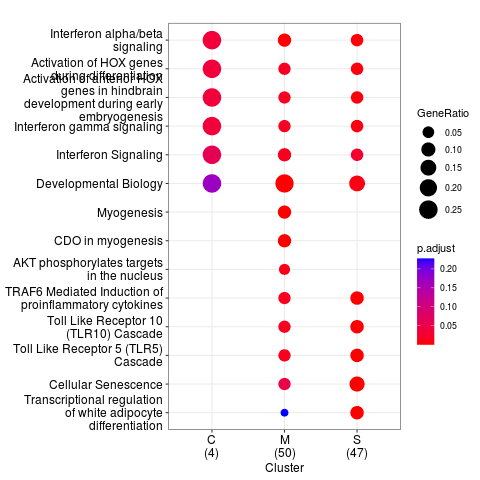

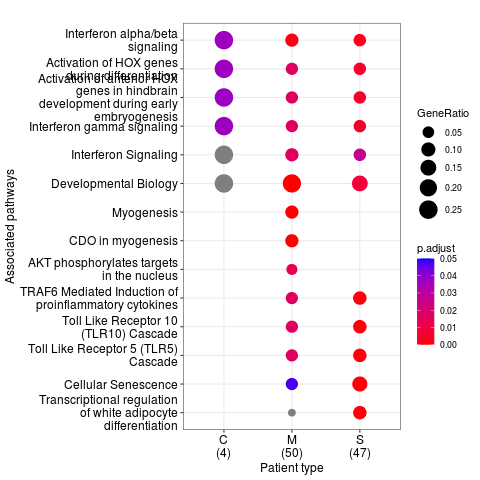

In [44]:
%%R
p <- dotplot(ck, showCategory=5) + 
    labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
# ggsave(p, filename=sprintf('%s/dotplot_enrichr_tf_markers_%s.pdf', fig_home, cell_type), width=7, height=8)
p

### Cnetplot

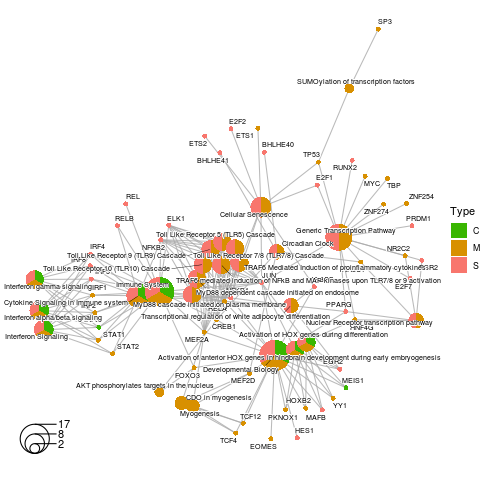

In [45]:
%%R
p <- cnetplot(ck, cex_category=1, 10) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
# ggsave(p, filename=sprintf('%s/cnetplot_enrichr_tf_markers_%s.pdf', fig_home, cell_type))
p

# Enrichment analysis on inferred communities in gene-gene regulatory networks

Now we can plot the visualizations depicting functional characterization of communities in GRNs.

## T cells

```python
python run_enrichr.py -i /gpfs/projects/bsc08/shared_projects/scGRN_analysis/Data_home/res/covid_19/cell_types/T_cells/data/grnboost2/leiden_communities/raw_data_communities_info.pickle -g all_sorted_genes
```

### Loading the data

In [64]:
cell_type = 'T_cells'
types = ['C', 'M', 'S']
db = 'Reactome_2016'

community_data = scGRN.ana.get_community_info(cell_type='T_cells')

df = pd.concat([
        pd.DataFrame({
            'cluster': f'cluster_{i}',
            'gene': [el[: el.find(' ')] for el in vals.split('; ')][:run_top_n]
        }) for i, vals in community_data['all_sorted_genes'].iteritems()
], axis=0).reset_index(drop=True)
types = list(df['cluster'].unique())
num_nodes_per_cluster = community_data['num_nodes'].rename(lambda x: f'cluster_{x}')

genes = {
    cl: df[df['cluster'] == cl]['gene'].to_list() for cl in df['cluster'].unique()
}

enrichr_res = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'grnboost2', f'{algo}_communities', 
    f'enrichr_{db}_raw_data_communities_info.tsv'
), sep='\t')

print('The community central genes:')
display(community_data['all_sorted_genes'])
print()
print('Corresponding enriched functional terms using EnrichR:')
display(enrichr_res)

The community central genes:


0     DUSP1 (score=0.18998955572905765); IL7R (score...
1     CCL5 (score=0.33543835396789073); ZNF683 (scor...
2     HLA-C (score=0.33831786810100817); HLA-A (scor...
3     ACTG1 (score=0.22816198967152546); ACTB (score...
4     CCL2 (score=0.20395934613870187); FTH1 (score=...
5     STMN1 (score=0.19471379122285665); HMGB2 (scor...
6     ISG15 (score=0.2147048155497237); SAT1 (score=...
7     EEF1A1 (score=0.20307412760151444); PABPC1 (sc...
8     FAM183A (score=0.24097835830452044); C9orf24 (...
9     RPS10 (score=0.15061539372895336); MT-ATP6 (sc...
10    CTLA4 (score=0.22315591619676342); SRGN (score...
11    IGHG1 (score=0.1369453044375645); IGLV3-19 (sc...
12                  HOXA5 (score=0.0); CIB2 (score=0.0)
Name: all_sorted_genes, dtype: object


Corresponding enriched functional terms using EnrichR:


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,cluster
0,Immune System Homo sapiens R-HSA-168256,16/1547,5.971219e-07,0.000133,0,0,5.661505,81.135852,JUN;DUSP2;KLRB1;DUSP1;FOS;RASGRP2;TNF;NFKBIA;S...,cluster_0
1,Cytokine Signaling in Immune system Homo sapie...,8/620,1.386370e-04,0.012570,0,0,6.018674,53.467806,SOCS2;DUSP2;DUSP1;LTA;IL17F;IL7R;TNF;IL17A,cluster_0
2,Interleukin-17 signaling Homo sapiens R-HSA-44...,2/8,1.698630e-04,0.012570,0,0,138.500000,1202.251780,IL17F;IL17A,cluster_0
3,Activation of the AP-1 family of transcription...,2/10,2.721231e-04,0.015103,0,0,103.864583,852.650959,JUN;FOS,cluster_0
4,Fc epsilon receptor (FCERI) signaling Homo sap...,6/395,4.357214e-04,0.018447,0,0,6.857093,53.063664,NFKBIA;JUN;DUSP2;DUSP1;FOS;RASGRP2,cluster_0
...,...,...,...,...,...,...,...,...,...,...
2172,Transmembrane transport of small molecules Hom...,1/594,7.789512e-01,0.808621,0,0,0.666173,0.166415,SLC2A5,cluster_11
2173,Gene Expression Homo sapiens R-HSA-74160,3/1631,7.857353e-01,0.808621,0,0,0.718360,0.173222,GTF3C2;MYBBP1A;ELL2,cluster_11
2174,Metabolism of lipids and lipoproteins Homo sap...,1/659,8.131293e-01,0.828766,0,0,0.598350,0.123778,AGPAT5,cluster_11
2175,Developmental Biology Homo sapiens R-HSA-1266738,1/786,8.656296e-01,0.873874,0,0,0.498245,0.071896,COL4A4,cluster_11


### Processing the data

We need to process the `EnrichR` output to use `clusterProfiler` for visualization.

In [65]:
processed_types = enrichr_res['cluster'].unique()
enrichr_res_processed = (
    enrichr_res.rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score', 'cluster': 'type'})
        .assign(
            Genes=enrichr_res['Genes'].map(lambda x: x.replace(';', '/')),
            Ratio=enrichr_res.apply(
                lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[x['cluster']])}", 
                axis=1
            )
        )        
)
if db == 'Reactome_2016':
    enrichr_res_processed['Term'] = enrichr_res_processed['Term'].map(lambda x: x[:x.find('Homo')-1])
final_df = enrichr_res_processed.assign(ID=[f'ID_{el}' for el in pd.factorize(enrichr_res_processed['Term'])[0] + 1])

print('Processed dataframe:')
final_df

Processed


,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Immune System,16/1547,5.971219e-07,0.000133,0,0,5.661505,81.135852,JUN/DUSP2/KLRB1/DUSP1/FOS/RASGRP2/TNF/NFKBIA/S...,cluster_0,16/50,ID_1
1,Cytokine Signaling in Immune system,8/620,1.386370e-04,0.012570,0,0,6.018674,53.467806,SOCS2/DUSP2/DUSP1/LTA/IL17F/IL7R/TNF/IL17A,cluster_0,8/50,ID_2
2,Interleukin-17 signaling,2/8,1.698630e-04,0.012570,0,0,138.500000,1202.251780,IL17F/IL17A,cluster_0,2/50,ID_3
3,Activation of the AP-1 family of transcription...,2/10,2.721231e-04,0.015103,0,0,103.864583,852.650959,JUN/FOS,cluster_0,2/50,ID_4
4,Fc epsilon receptor (FCERI) signaling,6/395,4.357214e-04,0.018447,0,0,6.857093,53.063664,NFKBIA/JUN/DUSP2/DUSP1/FOS/RASGRP2,cluster_0,6/50,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
2172,Transmembrane transport of small molecules,1/594,7.789512e-01,0.808621,0,0,0.666173,0.166415,SLC2A5,cluster_11,1/50,ID_210
2173,Gene Expression,3/1631,7.857353e-01,0.808621,0,0,0.718360,0.173222,GTF3C2/MYBBP1A/ELL2,cluster_11,3/50,ID_64
2174,Metabolism of lipids and lipoproteins,1/659,8.131293e-01,0.828766,0,0,0.598350,0.123778,AGPAT5,cluster_11,1/50,ID_86
2175,Developmental Biology,1/786,8.656296e-01,0.873874,0,0,0.498245,0.071896,COL4A4,cluster_11,1/50,ID_129


### Moving to `R` using `rpy2`

In [66]:
%%R -i final_df,processed_types,num_nodes_per_cluster,fig_home,cell_type

# Define some useful functions
get_cl_from_tick <- function (x) substr(x, 1, as.integer(gregexpr('\n', x)) - 1)
cl_name_to_int <- function (x) substr(x, as.integer(gregexpr('_', x)) + 1, nchar(x))

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

merge_cmd = ""
for (t in processed_types){
    merge_cmd = paste0(merge_cmd, sprintf("%s=egos[['%s']], ", t, t))
}

merge_cmd = sprintf("merge_result(list(%s))", substr(merge_cmd, 1, nchar(merge_cmd) - 2))

ck <- eval(parse(text=merge_cmd))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



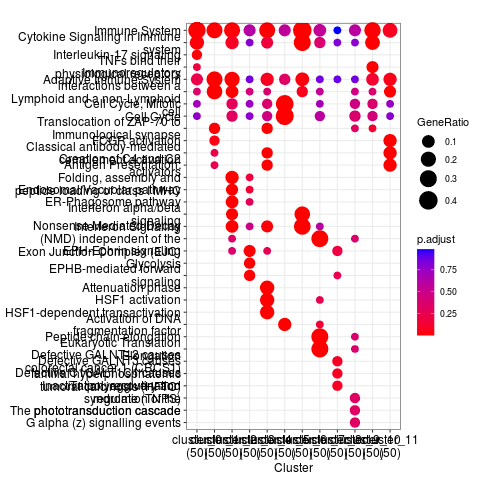

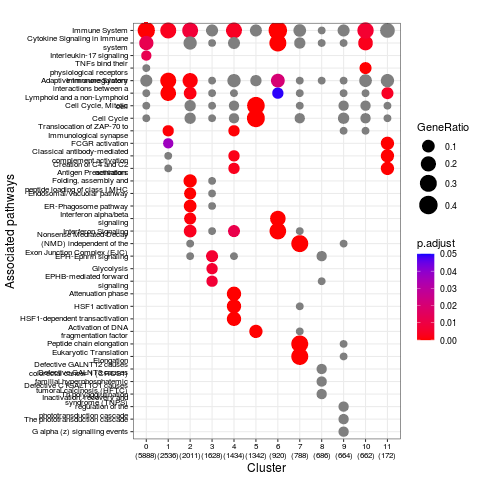

In [67]:
%%R
p <- dotplot(ck, showCategory=3) + 
    labs(y = 'Associated pathways', x = 'Cluster') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red") +
    theme(axis.text.y = element_text(size = 8), axis.text.x = element_text(size=8))
    
new_ticks <- lapply(ggplot_build(p)$layout$panel_params[[1]]$x.sec$scale$range$range, 
                    function (x) paste0(cl_name_to_int(get_cl_from_tick(x)), '\n', sprintf('(%s)', num_nodes_per_cluster[[get_cl_from_tick(x)]])))
p <- p + scale_x_discrete(labels=new_ticks)
    
# ggsave(p, filename=sprintf('%s/dotplot_enrichr_community_%s.pdf', fig_home, cell_type), width=7, height=8)
p

### Cnetplot

R[write to console]: Saving 6.67 x 6.67 in image



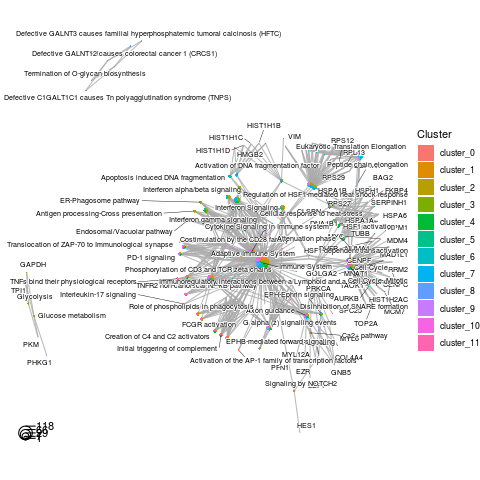

In [69]:
%%R
p <- cnetplot(ck, cex_category=1) +
    guides(fill=guide_legend(title="Cluster"))
p <- remove_legend_title(p)
# ggsave(p, filename=sprintf('%s/cnetplot_enrichr_community_%s.pdf', fig_home, cell_type))
p

## Macrophages

```python
python run_enrichr.py -i /gpfs/projects/bsc08/shared_projects/scGRN_analysis/Data_home/res/covid_19/cell_types/Macrophage/data/grnboost2/leiden_communities/raw_data_communities_info.pickle -g all_sorted_genes
```

### Loading the data

In [81]:
cell_type = 'Macrophage'
types = ['C', 'M', 'S']
db = 'Reactome_2016'

community_data = scGRN.ana.get_community_info(cell_type=cell_type)

df = pd.concat([
        pd.DataFrame({
            'cluster': f'cluster_{i}',
            'gene': [el[: el.find(' ')] for el in vals.split('; ')][:run_top_n]
        }) for i, vals in community_data['all_sorted_genes'].iteritems()
], axis=0).reset_index(drop=True)
types = list(df['cluster'].unique())
num_nodes_per_cluster = community_data['num_nodes'].rename(lambda x: f'cluster_{x}')

genes = {
    cl: df[df['cluster'] == cl]['gene'].to_list() for cl in df['cluster'].unique()
}

enrichr_res = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'grnboost2', f'{algo}_communities', 
    f'enrichr_{db}_raw_data_communities_info.tsv'
), sep='\t')

print('The community central genes:')
display(community_data['all_sorted_genes'])
print()
print('Corresponding enriched functional terms using EnrichR:')
display(enrichr_res)

The community central genes:


0     MALAT1 (score=0.17686992580240085); AL138963.3...
1     CTSL (score=0.24700503930849096); SAT1 (score=...
2     CD52 (score=0.224319937968812); TMSB4X (score=...
3     ACTB (score=0.2401380792568832); CALR (score=0...
4     HSPA1A (score=0.11022338152625277); HSPA6 (sco...
5     IL32 (score=0.0884645344144753); HIST1H4C (sco...
6     GSTA1 (score=0.13503916626354695); FAM92B (sco...
7     AC020656.1 (score=0.03526849292116947); RASSF3...
8     IGKV2-24 (score=0.15570424891267984); IGKC (sc...
9     LINC01675 (score=0.16666666666666666); KRTAP5-...
10                SMTNL2 (score=0.0); CAPN5 (score=0.0)
Name: all_sorted_genes, dtype: object


Corresponding enriched functional terms using EnrichR:


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,cluster
0,Ubiquinol biosynthesis Homo sapiens R-HSA-2142789,1/7,0.017372,0.381484,0,0,67.836735,274.936211,PDSS2,cluster_0
1,Post-transcriptional silencing by small RNAs H...,1/7,0.017372,0.381484,0,0,67.836735,274.936211,TNRC6A,cluster_0
2,Hydrolysis of LPC Homo sapiens R-HSA-1483115,1/8,0.019829,0.381484,0,0,58.142857,227.954980,GPCPD1,cluster_0
3,Interleukin-17 signaling Homo sapiens R-HSA-44...,1/8,0.019829,0.381484,0,0,58.142857,227.954980,IL17RC,cluster_0
4,Oxidative Stress Induced Senescence Homo sapie...,2/91,0.021774,0.381484,0,0,9.298221,35.584818,MAPKAPK5;TNRC6A,cluster_0
...,...,...,...,...,...,...,...,...,...,...
1426,Disease Homo sapiens R-HSA-1643685,1/725,0.842522,0.868851,0,0,0.541944,0.092865,CD320,cluster_8
1427,Gene Expression Homo sapiens R-HSA-74160,2/1631,0.922922,0.937121,0,0,0.468616,0.037588,EHMT1;ZNF136,cluster_8
1428,Signal Transduction Homo sapiens R-HSA-162582,2/2465,0.988886,0.988886,0,0,0.295828,0.003306,IFT88;PDK4,cluster_8
1429,Degradation of the extracellular matrix Homo s...,1/106,0.010572,0.021144,0,0,189.457143,861.942822,CAPN5,cluster_10


### Processing the data

We need to process the `EnrichR` output to use `clusterProfiler` for visualization.

In [82]:
processed_types = enrichr_res['cluster'].unique()
enrichr_res_processed = (
    enrichr_res.rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score', 'cluster': 'type'})
        .assign(
            Genes=enrichr_res['Genes'].map(lambda x: x.replace(';', '/')),
            Ratio=enrichr_res.apply(
                lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[x['cluster']])}", 
                axis=1
            )
        )        
)
if db == 'Reactome_2016':
    enrichr_res_processed['Term'] = enrichr_res_processed['Term'].map(lambda x: x[:x.find('Homo')-1])
final_df = enrichr_res_processed.assign(ID=[f'ID_{el}' for el in pd.factorize(enrichr_res_processed['Term'])[0] + 1])

print('Processed dataframe:')
final_df

Processed dataframe:


,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Ubiquinol biosynthesis,1/7,0.017372,0.381484,0,0,67.836735,274.936211,PDSS2,cluster_0,1/50,ID_1
1,Post-transcriptional silencing by small RNAs,1/7,0.017372,0.381484,0,0,67.836735,274.936211,TNRC6A,cluster_0,1/50,ID_2
2,Hydrolysis of LPC,1/8,0.019829,0.381484,0,0,58.142857,227.954980,GPCPD1,cluster_0,1/50,ID_3
3,Interleukin-17 signaling,1/8,0.019829,0.381484,0,0,58.142857,227.954980,IL17RC,cluster_0,1/50,ID_4
4,Oxidative Stress Induced Senescence,2/91,0.021774,0.381484,0,0,9.298221,35.584818,MAPKAPK5/TNRC6A,cluster_0,2/50,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
1426,Disease,1/725,0.842522,0.868851,0,0,0.541944,0.092865,CD320,cluster_8,1/50,ID_263
1427,Gene Expression,2/1631,0.922922,0.937121,0,0,0.468616,0.037588,EHMT1/ZNF136,cluster_8,2/50,ID_23
1428,Signal Transduction,2/2465,0.988886,0.988886,0,0,0.295828,0.003306,IFT88/PDK4,cluster_8,2/50,ID_103
1429,Degradation of the extracellular matrix,1/106,0.010572,0.021144,0,0,189.457143,861.942822,CAPN5,cluster_10,1/2,ID_156


### Moving to `R` using `rpy2`

In [83]:
%%R -i final_df,processed_types,num_nodes_per_cluster,fig_home,cell_type

# Define some useful functions
get_cl_from_tick <- function (x) substr(x, 1, as.integer(gregexpr('\n', x)) - 1)
cl_name_to_int <- function (x) substr(x, as.integer(gregexpr('_', x)) + 1, nchar(x))

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

merge_cmd = ""
for (t in processed_types){
    merge_cmd = paste0(merge_cmd, sprintf("%s=egos[['%s']], ", t, t))
}

merge_cmd = sprintf("merge_result(list(%s))", substr(merge_cmd, 1, nchar(merge_cmd) - 2))

ck <- eval(parse(text=merge_cmd))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



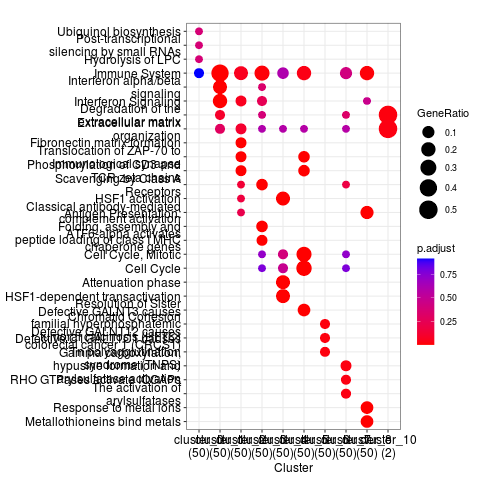

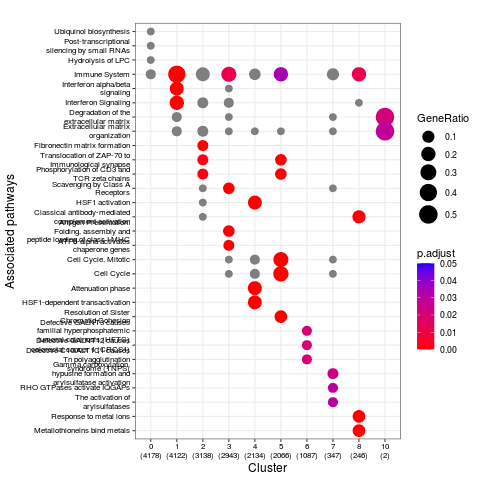

In [84]:
%%R
p <- dotplot(ck, showCategory=3) + 
    labs(y = 'Associated pathways', x = 'Cluster') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red") +
    theme(axis.text.y = element_text(size = 8), axis.text.x = element_text(size=8))
    
new_ticks <- lapply(ggplot_build(p)$layout$panel_params[[1]]$x.sec$scale$range$range, 
                    function (x) paste0(cl_name_to_int(get_cl_from_tick(x)), '\n', sprintf('(%s)', num_nodes_per_cluster[[get_cl_from_tick(x)]])))
p <- p + scale_x_discrete(labels=new_ticks)
    
# ggsave(p, filename=sprintf('%s/dotplot_enrichr_community_%s.pdf', fig_home, cell_type), width=7, height=8)
p

### Cnetplot

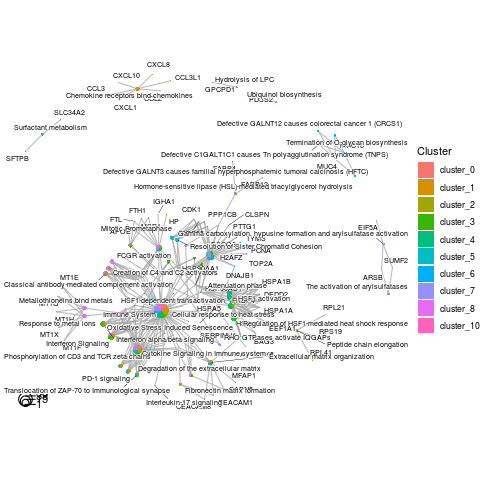

In [85]:
%%R
p <- cnetplot(ck, cex_category=1) +
    guides(fill=guide_legend(title="Cluster"))
p <- remove_legend_title(p)
# ggsave(p, filename=sprintf('%s/cnetplot_enrichr_community_%s.pdf', fig_home, cell_type))
p

## NK cells

```python
python run_enrichr.py -i /gpfs/projects/bsc08/shared_projects/scGRN_analysis/Data_home/res/covid_19/cell_types/NK_cell/data/grnboost2/leiden_communities/raw_data_communities_info.pickle -g all_sorted_genes
```

### Loading the data

In [86]:
cell_type = 'NK_cell'
types = ['C', 'M', 'S']
db = 'Reactome_2016'

community_data = scGRN.ana.get_community_info(cell_type=cell_type)

df = pd.concat([
        pd.DataFrame({
            'cluster': f'cluster_{i}',
            'gene': [el[: el.find(' ')] for el in vals.split('; ')][:run_top_n]
        }) for i, vals in community_data['all_sorted_genes'].iteritems()
], axis=0).reset_index(drop=True)
types = list(df['cluster'].unique())
num_nodes_per_cluster = community_data['num_nodes'].rename(lambda x: f'cluster_{x}')

genes = {
    cl: df[df['cluster'] == cl]['gene'].to_list() for cl in df['cluster'].unique()
}

enrichr_res = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'grnboost2', f'{algo}_communities', 
    f'enrichr_{db}_raw_data_communities_info.tsv'
), sep='\t')

print('The community central genes:')
display(community_data['all_sorted_genes'])
print()
print('Corresponding enriched functional terms using EnrichR:')
display(enrichr_res)

The community central genes:


0     TRDV1 (score=0.16169789569460258); TRGV2 (scor...
1     IFITM1 (score=0.2857252159267133); IFITM3 (sco...
2     FTH1 (score=0.2758207367327068); FTL (score=0....
3     STMN1 (score=0.24264588257227226); HMGB2 (scor...
4     XCL2 (score=0.0822399541564627); CITED2 (score...
5     TPT1 (score=0.2008068258687684); LTB (score=0....
6     RPS10 (score=0.10174195596391757); GABPB1-AS1 ...
7     GNLY (score=0.22050005731568598); CCL4 (score=...
8     CPNE3 (score=0.08824950123119506); OS9 (score=...
9     ACTB (score=0.27166684028380617); GAPDH (score...
10    CX3CR1 (score=0.2668901051022714); PRSS23 (sco...
11    AREG (score=0.23015759983509174); HDC (score=0...
12    DVL3 (score=0.06587190275829828); REEP3 (score...
13    APOC1 (score=0.28850804294325355); C1QB (score...
14    AL138963.3 (score=0.09691924990432453); ADAM19...
15    HLA-DQA1 (score=0.1824295513533556); CD74 (sco...
16    BAG3 (score=0.21022358665430954); HSPB1 (score...
17    CXXC5 (score=0.14669838523644751); POLD1 (


Corresponding enriched functional terms using EnrichR:


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,cluster
0,Immunoregulatory interactions between a Lympho...,7/157,1.208484e-07,0.000014,0,0,21.488372,342.282462,CD8B;CD8A;TRAC;CD3G;SLAMF6;CD3E;CD3D,cluster_0
1,Translocation of ZAP-70 to Immunological synap...,4/21,2.004167e-07,0.000014,0,0,101.959079,1572.501325,TRAC;CD3G;CD3E;CD3D,cluster_0
2,Phosphorylation of CD3 and TCR zeta chains Hom...,4/24,3.538708e-07,0.000016,0,0,86.652174,1287.160341,TRAC;CD3G;CD3E;CD3D,cluster_0
3,PD-1 signaling Homo sapiens R-HSA-389948,4/26,4.960429e-07,0.000017,0,0,78.766798,1143.426372,TRAC;CD3G;CD3E;CD3D,cluster_0
4,Generation of second messenger molecules Homo ...,4/35,1.708801e-06,0.000047,0,0,55.873773,741.987985,TRAC;CD3G;CD3E;CD3D,cluster_0
...,...,...,...,...,...,...,...,...,...,...
4021,Metabolism Homo sapiens R-HSA-1430728,4/1908,7.151270e-01,0.729288,0,0,0.824169,0.276340,HS3ST3B1;GNG3;MGST2;MGLL,cluster_20
4022,Axon guidance Homo sapiens R-HSA-422475,1/515,7.290944e-01,0.739869,0,0,0.771699,0.243820,RPS6KA3,cluster_20
4023,Post-translational protein modification Homo s...,1/521,7.332392e-01,0.740428,0,0,0.762559,0.236609,NAGK,cluster_20
4024,Gene Expression Homo sapiens R-HSA-74160,3/1631,7.857353e-01,0.789568,0,0,0.718360,0.173222,HIST1H4A;ELL3;MPHOSPH6,cluster_20


### Processing the data

We need to process the `EnrichR` output to use `clusterProfiler` for visualization.

In [87]:
processed_types = enrichr_res['cluster'].unique()
enrichr_res_processed = (
    enrichr_res.rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score', 'cluster': 'type'})
        .assign(
            Genes=enrichr_res['Genes'].map(lambda x: x.replace(';', '/')),
            Ratio=enrichr_res.apply(
                lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[x['cluster']])}", 
                axis=1
            )
        )        
)
if db == 'Reactome_2016':
    enrichr_res_processed['Term'] = enrichr_res_processed['Term'].map(lambda x: x[:x.find('Homo')-1])
final_df = enrichr_res_processed.assign(ID=[f'ID_{el}' for el in pd.factorize(enrichr_res_processed['Term'])[0] + 1])

print('Processed dataframe:')
final_df

Processed dataframe:


,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Immunoregulatory interactions between a Lympho...,7/157,1.208484e-07,0.000014,0,0,21.488372,342.282462,CD8B/CD8A/TRAC/CD3G/SLAMF6/CD3E/CD3D,cluster_0,7/50,ID_1
1,Translocation of ZAP-70 to Immunological synapse,4/21,2.004167e-07,0.000014,0,0,101.959079,1572.501325,TRAC/CD3G/CD3E/CD3D,cluster_0,4/50,ID_2
2,Phosphorylation of CD3 and TCR zeta chains,4/24,3.538708e-07,0.000016,0,0,86.652174,1287.160341,TRAC/CD3G/CD3E/CD3D,cluster_0,4/50,ID_3
3,PD-1 signaling,4/26,4.960429e-07,0.000017,0,0,78.766798,1143.426372,TRAC/CD3G/CD3E/CD3D,cluster_0,4/50,ID_4
4,Generation of second messenger molecules,4/35,1.708801e-06,0.000047,0,0,55.873773,741.987985,TRAC/CD3G/CD3E/CD3D,cluster_0,4/50,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
4021,Metabolism,4/1908,7.151270e-01,0.729288,0,0,0.824169,0.276340,HS3ST3B1/GNG3/MGST2/MGLL,cluster_20,4/50,ID_137
4022,Axon guidance,1/515,7.290944e-01,0.739869,0,0,0.771699,0.243820,RPS6KA3,cluster_20,1/50,ID_300
4023,Post-translational protein modification,1/521,7.332392e-01,0.740428,0,0,0.762559,0.236609,NAGK,cluster_20,1/50,ID_396
4024,Gene Expression,3/1631,7.857353e-01,0.789568,0,0,0.718360,0.173222,HIST1H4A/ELL3/MPHOSPH6,cluster_20,3/50,ID_104


### Moving to `R` using `rpy2`

In [88]:
%%R -i final_df,processed_types,num_nodes_per_cluster,fig_home,cell_type

# Define some useful functions
get_cl_from_tick <- function (x) substr(x, 1, as.integer(gregexpr('\n', x)) - 1)
cl_name_to_int <- function (x) substr(x, as.integer(gregexpr('_', x)) + 1, nchar(x))

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

merge_cmd = ""
for (t in processed_types){
    merge_cmd = paste0(merge_cmd, sprintf("%s=egos[['%s']], ", t, t))
}

merge_cmd = sprintf("merge_result(list(%s))", substr(merge_cmd, 1, nchar(merge_cmd) - 2))

ck <- eval(parse(text=merge_cmd))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



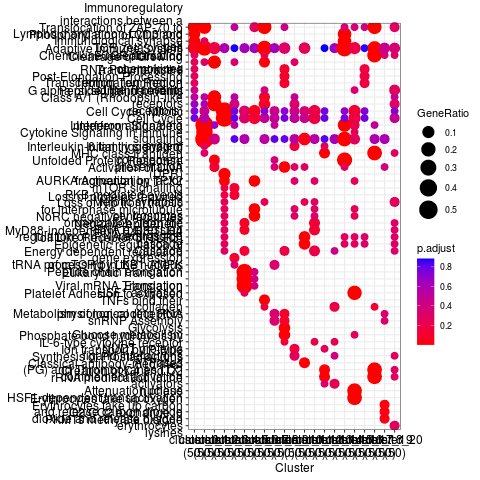

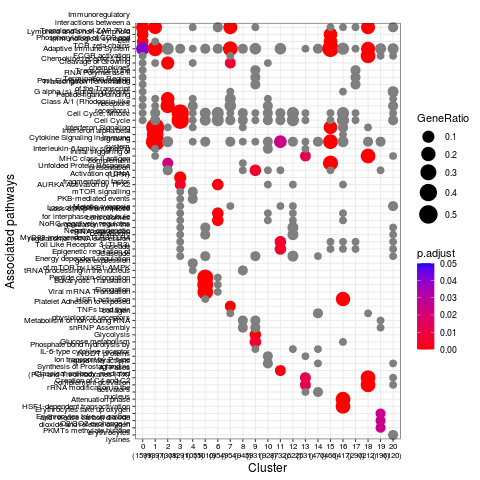

In [89]:
%%R
p <- dotplot(ck, showCategory=3) + 
    labs(y = 'Associated pathways', x = 'Cluster') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red") +
    theme(axis.text.y = element_text(size = 8), axis.text.x = element_text(size=8))
    
new_ticks <- lapply(ggplot_build(p)$layout$panel_params[[1]]$x.sec$scale$range$range, 
                    function (x) paste0(cl_name_to_int(get_cl_from_tick(x)), '\n', sprintf('(%s)', num_nodes_per_cluster[[get_cl_from_tick(x)]])))
p <- p + scale_x_discrete(labels=new_ticks)
    
# ggsave(p, filename=sprintf('%s/dotplot_enrichr_community_%s.pdf', fig_home, cell_type), width=7, height=8)
p

### Cnetplot

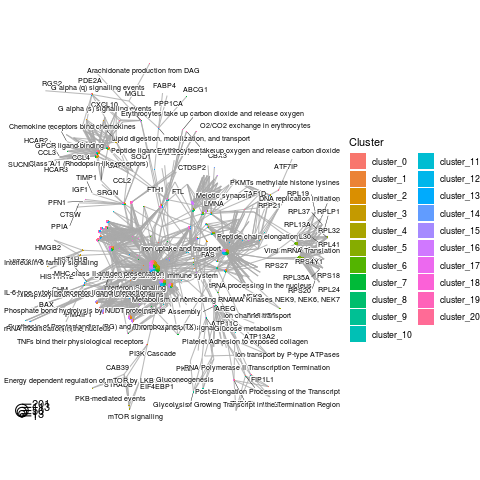

In [90]:
%%R
p <- cnetplot(ck, cex_category=1) +
    guides(fill=guide_legend(title="Cluster"))
p <- remove_legend_title(p)
# ggsave(p, filename=sprintf('%s/cnetplot_enrichr_community_%s.pdf', fig_home, cell_type))
p